## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import glob
import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import copy
import pandas as pd
import numpy as np
import torch

from sklearn.metrics import roc_auc_score

os.environ["WANDB_SILENT"] = "true"

from owkin.training import train, RocLoss
from owkin.dataset import build_dataset
from owkin.models.mono_models import MLP, SVM, LogReg
from owkin.models.aggregators import SmoothMaxAggregator, MaxAggregator

## Training

In [3]:
normalizer_type = "None"

In [4]:
list_C = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3]
list_penalty = ["l1", 'l2']
list_val_center = ["C_1", "C_2", "C_5"]

In [5]:
mono_res = {}
smooth_max_res = {}
max_res = {}

for val_center in list_val_center:
    mono_res[val_center] = dict()
    smooth_max_res[val_center] = dict()
    max_res[val_center] = dict()
    for penalty in list_penalty:
        mono_res[val_center][penalty] = dict()
        smooth_max_res[val_center][penalty] = dict()
        max_res[val_center][penalty] = dict()

mono_res["mean"] = dict()
smooth_max_res["mean"] = dict()
max_res["mean"] = dict()
for penalty in list_penalty:
    mono_res["mean"][penalty] = dict()
    smooth_max_res["mean"][penalty] = dict()
    max_res["mean"][penalty] = dict()
    for C in list_C:
        mono_res["mean"][penalty][C] = 0
        smooth_max_res["mean"][penalty][C] = 0
        max_res["mean"][penalty][C] = 0

In [6]:
for val_center in list_val_center:
    X_train, X_train_mean, y_train, X_val, X_val_mean, y_val, X_test, X_test_mean, df_test = build_dataset(normalizer_type=normalizer_type, val_center=val_center)
    for penalty in list_penalty:
        for C in list_C:    
            mono_model = LogReg(C=C, penalty=penalty)
            mono_model.sk_model.fit(X_train_mean, y_train)
            
            smooth_max_model = SmoothMaxAggregator(mono_model)
            max_model = MaxAggregator(mono_model)

            mono_val_pred = mono_model(X_val_mean)
            smooth_max_val_pred = smooth_max_model(X_val)
            max_val_pred = max_model(X_val)
            
            mono_res[val_center][penalty][C] = roc_auc_score(y_val, mono_val_pred)
            smooth_max_res[val_center][penalty][C] = roc_auc_score(y_val, smooth_max_val_pred)
            max_res[val_center][penalty][C] = roc_auc_score(y_val, max_val_pred)

            mono_res["mean"][penalty][C] += roc_auc_score(y_val, mono_val_pred) / len(list_val_center)
            smooth_max_res["mean"][penalty][C] += roc_auc_score(y_val, smooth_max_val_pred) / len(list_val_center)
            max_res["mean"][penalty][C] += roc_auc_score(y_val, max_val_pred) / len(list_val_center)

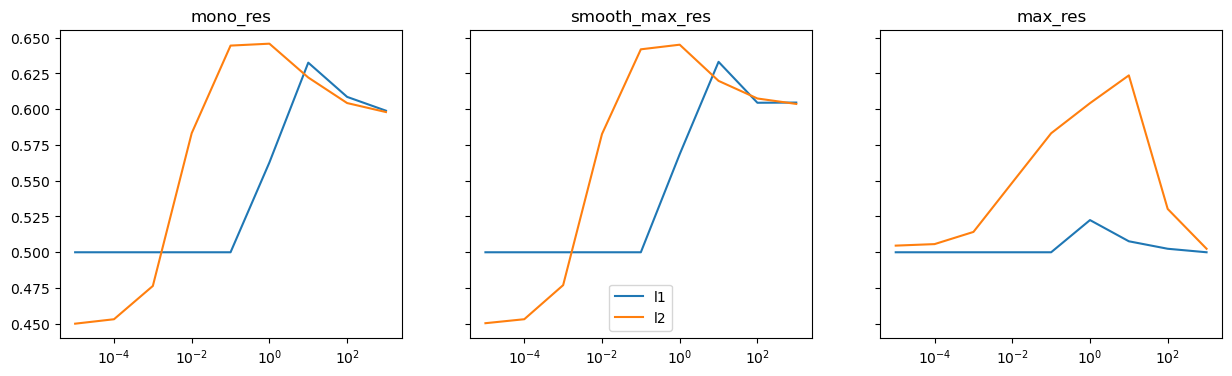

In [7]:
fig, ax = plt.subplots(1,3, figsize=(15,4), sharey=True)
for penalty in list_penalty:
    ax[0].plot(list(mono_res["mean"][penalty].keys()), list(mono_res["mean"][penalty].values()), label = penalty)
    ax[1].plot(list(smooth_max_res["mean"][penalty].keys()), list(smooth_max_res["mean"][penalty].values()), label = penalty)
    ax[2].plot(list(max_res["mean"][penalty].keys()), list(max_res["mean"][penalty].values()), label = penalty)

ax[0].set_xscale('log')
ax[0].set_title("mono_res")

ax[1].set_xscale('log')
ax[1].set_title("smooth_max_res")
ax[1].legend(loc = "lower center")

ax[2].set_xscale('log')
ax[2].set_title("max_res")

plt.show()

In [9]:
for C in list_C:
    print("C:", C)
    print("mono_res:", mono_res["mean"]["l2"][C])
    print("smooth_max_res:", smooth_max_res["mean"]["l2"][C])
    print()

C: 1e-05
mono_res: 0.4500891503554044
smooth_max_res: 0.4504256595413467

C: 0.0001
mono_res: 0.4531881401006561
smooth_max_res: 0.45320320474888953

C: 0.001
mono_res: 0.47645911475447533
smooth_max_res: 0.47701465060629633

C: 0.01
mono_res: 0.5832238820467761
smooth_max_res: 0.582645193308984

C: 0.1
mono_res: 0.6444486836842032
smooth_max_res: 0.6418478090973864

C: 1.0
mono_res: 0.6457890685751716
smooth_max_res: 0.6450797928515657

C: 10.0
mono_res: 0.6221407753849824
smooth_max_res: 0.6197901645967039

C: 100.0
mono_res: 0.6042919004882963
smooth_max_res: 0.6074820937653926

C: 1000.0
mono_res: 0.5979932165850474
smooth_max_res: 0.6036736822718259



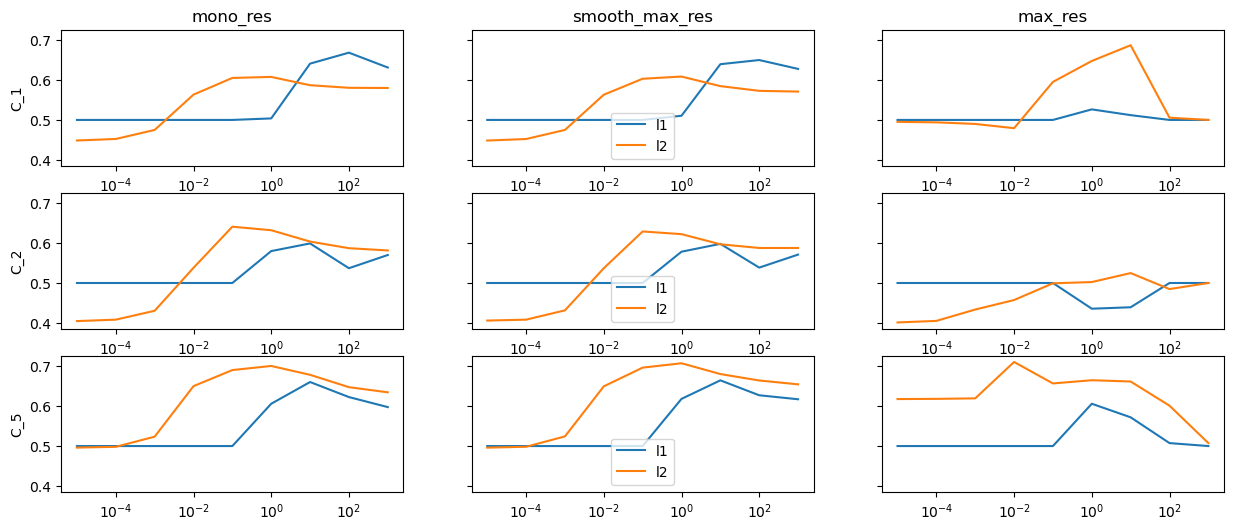

In [10]:
fig, ax = plt.subplots(3,3, figsize=(15,6), sharey=True)
for i, val_center in enumerate(list_val_center):
    ax[i][0].plot(list(mono_res[val_center]["l1"].keys()), list(mono_res[val_center]["l1"].values()), label = f"l1")
    ax[i][1].plot(list(smooth_max_res[val_center]["l1"].keys()), list(smooth_max_res[val_center]["l1"].values()), label = f"l1")
    ax[i][2].plot(list(max_res[val_center]["l1"].keys()), list(max_res[val_center]["l1"].values()), label = f"l1")

    ax[i][0].plot(list(mono_res[val_center]["l2"].keys()), list(mono_res[val_center]["l2"].values()), label = f"l2")
    ax[i][1].plot(list(smooth_max_res[val_center]["l2"].keys()), list(smooth_max_res[val_center]["l2"].values()), label = f"l2")
    ax[i][2].plot(list(max_res[val_center]["l2"].keys()), list(max_res[val_center]["l2"].values()), label = f"l2")

    ax[i][0].set_xscale('log')
    ax[i][0].set_ylabel(val_center)

    ax[i][1].set_xscale('log')
    ax[i][1].legend(loc = "lower center")

    ax[i][2].set_xscale('log')

ax[0][0].set_title("mono_res")
ax[0][1].set_title("smooth_max_res")
ax[0][2].set_title("max_res")

plt.show()

## expo_lambda

In [11]:
normalizer_type = "expo_lambda"

In [12]:
mono_res = {}
smooth_max_res = {}
max_res = {}

for val_center in list_val_center:
    mono_res[val_center] = dict()
    smooth_max_res[val_center] = dict()
    max_res[val_center] = dict()
    for penalty in list_penalty:
        mono_res[val_center][penalty] = dict()
        smooth_max_res[val_center][penalty] = dict()
        max_res[val_center][penalty] = dict()

mono_res["mean"] = dict()
smooth_max_res["mean"] = dict()
max_res["mean"] = dict()
for penalty in list_penalty:
    mono_res["mean"][penalty] = dict()
    smooth_max_res["mean"][penalty] = dict()
    max_res["mean"][penalty] = dict()
    for C in list_C:
        mono_res["mean"][penalty][C] = 0
        smooth_max_res["mean"][penalty][C] = 0
        max_res["mean"][penalty][C] = 0

In [13]:
for val_center in list_val_center:
    X_train, X_train_mean, y_train, X_val, X_val_mean, y_val, X_test, X_test_mean, df_test = build_dataset(normalizer_type=normalizer_type, val_center=val_center)
    for penalty in list_penalty:
        for C in list_C:    
            mono_model = LogReg(C=C, penalty=penalty)
            mono_model.sk_model.fit(X_train_mean, y_train)
            
            smooth_max_model = SmoothMaxAggregator(mono_model)
            max_model = MaxAggregator(mono_model)

            mono_val_pred = mono_model(X_val_mean)
            smooth_max_val_pred = smooth_max_model(X_val)
            max_val_pred = max_model(X_val)
            
            mono_res[val_center][penalty][C] = roc_auc_score(y_val, mono_val_pred)
            smooth_max_res[val_center][penalty][C] = roc_auc_score(y_val, smooth_max_val_pred)
            max_res[val_center][penalty][C] = roc_auc_score(y_val, max_val_pred)

            mono_res["mean"][penalty][C] += roc_auc_score(y_val, mono_val_pred) / len(list_val_center)
            smooth_max_res["mean"][penalty][C] += roc_auc_score(y_val, smooth_max_val_pred) / len(list_val_center)
            max_res["mean"][penalty][C] += roc_auc_score(y_val, max_val_pred) / len(list_val_center)

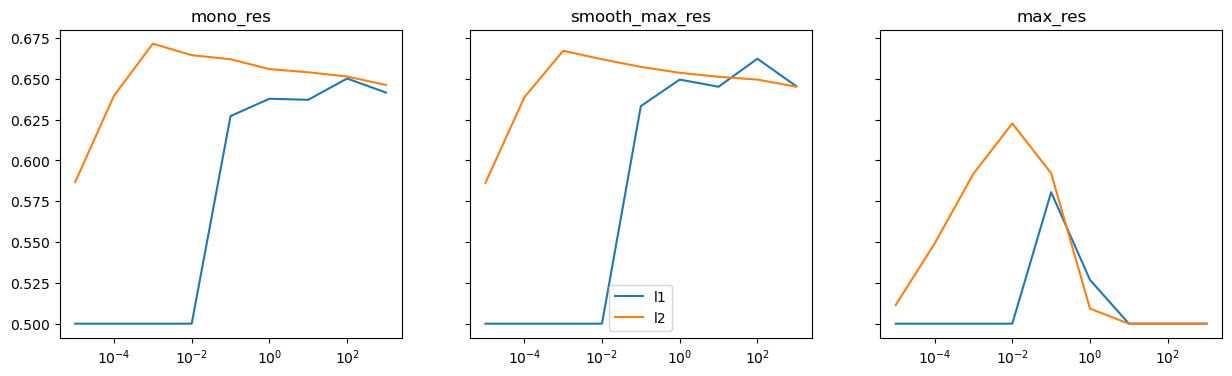

In [14]:
fig, ax = plt.subplots(1,3, figsize=(15,4), sharey=True)
for penalty in list_penalty:
    ax[0].plot(list(mono_res["mean"][penalty].keys()), list(mono_res["mean"][penalty].values()), label = penalty)
    ax[1].plot(list(smooth_max_res["mean"][penalty].keys()), list(smooth_max_res["mean"][penalty].values()), label = penalty)
    ax[2].plot(list(max_res["mean"][penalty].keys()), list(max_res["mean"][penalty].values()), label = penalty)

ax[0].set_xscale('log')
ax[0].set_title("mono_res")

ax[1].set_xscale('log')
ax[1].set_title("smooth_max_res")
ax[1].legend(loc = "lower center")

ax[2].set_xscale('log')
ax[2].set_title("max_res")

plt.show()

In [15]:
for C in list_C:
    print("C:", C)
    print("mono_res:", mono_res["mean"]["l2"][C])
    print("smooth_max_res:", smooth_max_res["mean"]["l2"][C])
    print()

C: 1e-05
mono_res: 0.5866228262993581
smooth_max_res: 0.5861921882366289

C: 0.0001
mono_res: 0.63958123279958
smooth_max_res: 0.6385216584824249

C: 0.001
mono_res: 0.6714292622465584
smooth_max_res: 0.6670910715765126

C: 0.01
mono_res: 0.6643834232453415
smooth_max_res: 0.6618896479495

C: 0.1
mono_res: 0.6619075638949075
smooth_max_res: 0.6572320830294953

C: 1.0
mono_res: 0.6558663589419932
smooth_max_res: 0.6536103752527532

C: 10.0
mono_res: 0.6539311461816784
smooth_max_res: 0.6511343904729298

C: 100.0
mono_res: 0.6513372440143083
smooth_max_res: 0.6494615801743706

C: 1000.0
mono_res: 0.6461452224897287
smooth_max_res: 0.6450472892447826



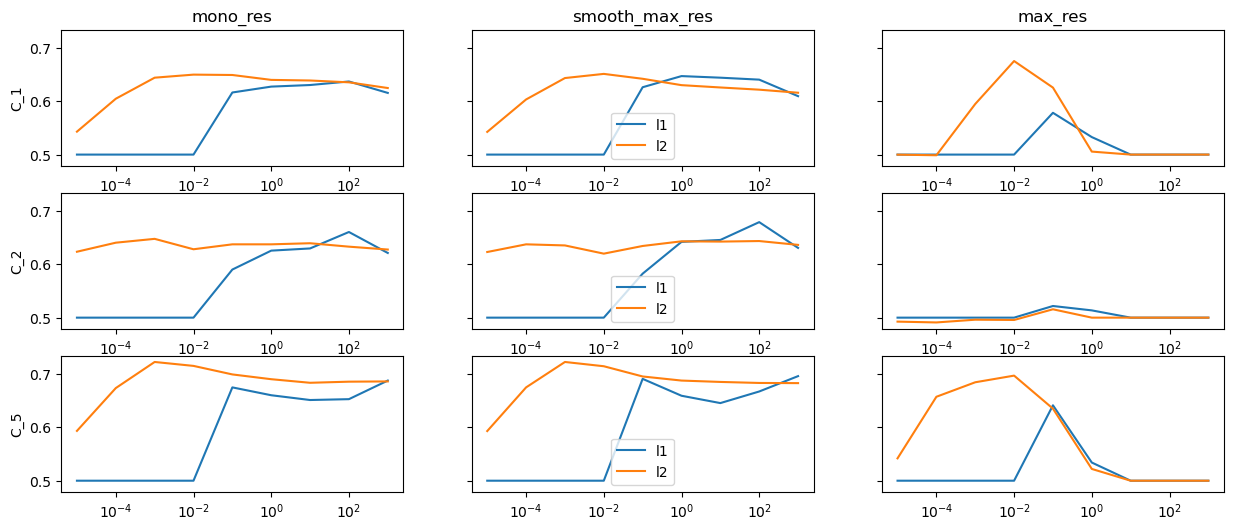

In [16]:
fig, ax = plt.subplots(3,3, figsize=(15,6), sharey=True)
for i, val_center in enumerate(list_val_center):
    ax[i][0].plot(list(mono_res[val_center]["l1"].keys()), list(mono_res[val_center]["l1"].values()), label = f"l1")
    ax[i][1].plot(list(smooth_max_res[val_center]["l1"].keys()), list(smooth_max_res[val_center]["l1"].values()), label = f"l1")
    ax[i][2].plot(list(max_res[val_center]["l1"].keys()), list(max_res[val_center]["l1"].values()), label = f"l1")

    ax[i][0].plot(list(mono_res[val_center]["l2"].keys()), list(mono_res[val_center]["l2"].values()), label = f"l2")
    ax[i][1].plot(list(smooth_max_res[val_center]["l2"].keys()), list(smooth_max_res[val_center]["l2"].values()), label = f"l2")
    ax[i][2].plot(list(max_res[val_center]["l2"].keys()), list(max_res[val_center]["l2"].values()), label = f"l2")

    ax[i][0].set_xscale('log')
    ax[i][0].set_ylabel(val_center)

    ax[i][1].set_xscale('log')
    ax[i][1].legend(loc = "lower center")

    ax[i][2].set_xscale('log')

ax[0][0].set_title("mono_res")
ax[0][1].set_title("smooth_max_res")
ax[0][2].set_title("max_res")

plt.show()